#Dataset

In [ ]:
!unzip dogs-vs-cats.zip -d '/content/imageclassification'

Archive:  /content/drive/MyDrive/Kuliah/dicoding/imageclassification/dogs-vs-cats.zip
  inflating: /content/drive/MyDrive/Kuliah/dicoding/imageclassification/sampleSubmission.csv  
  inflating: /content/drive/MyDrive/Kuliah/dicoding/imageclassification/test1.zip  
  inflating: /content/drive/MyDrive/Kuliah/dicoding/imageclassification/train.zip  


In [ ]:
!unzip /train.zip -d 'imageclassification/train'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras_preprocessing.image import load_img, ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
print(os.listdir('/imageclassification/'))

['sampleSubmission.csv', 'test1.zip', '.ipynb_checkpoints', 'model.h5', 'model_dogvscat.h5', 'tf_lite_model_dogvscat.tflite', 'train']


In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
filenames = os.listdir("/imageclassification/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.sample(10)

,filename,category
1891,cat.1124.jpg,0
968,dog.9971.jpg,1
3117,dog.8750.jpg,1
3799,dog.936.jpg,1
2161,cat.11481.jpg,0
3943,dog.9488.jpg,1
1855,cat.1122.jpg,0
288,cat.10271.jpg,0
3815,dog.9394.jpg,1
3539,dog.9109.jpg,1


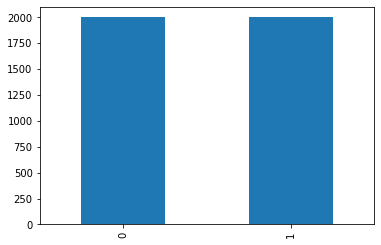

In [ ]:
df['category'].value_counts().plot.bar()

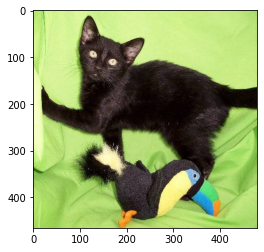

In [ ]:
sample = random.choice(filenames)
image = load_img("/imageclassification/train/"+sample)
plt.imshow(image)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

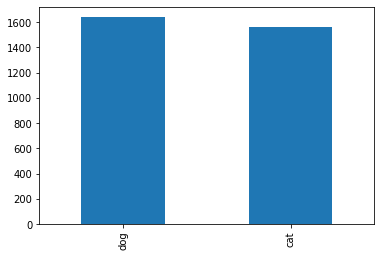

In [ ]:
train_df['category'].value_counts().plot.bar()

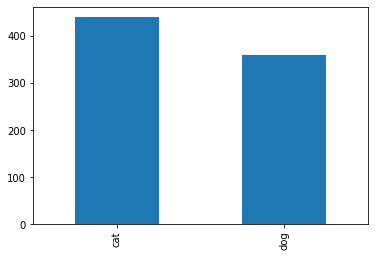

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/imageclassification/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/imageclassification/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/imageclassification/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


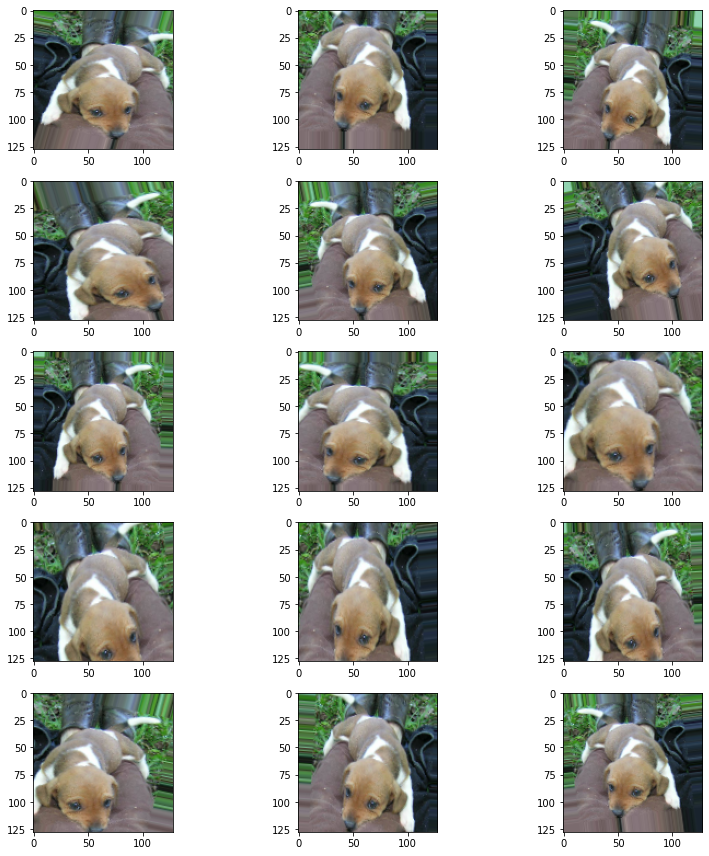

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-25-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
213/213 [==============================] - 61s 234ms/step - loss: 1.1323 - accuracy: 0.5736 - val_loss: 1.6347 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 2/50
213/213 [==============================] - 29s 134ms/step - loss: 0.7968 - accuracy: 0.6019 - val_loss: 0.8410 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 3/50
213/213 [==============================] - 28s 133ms/step - loss: 0.6840 - accuracy: 0.6323 - val_loss: 0.6691 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 4/50
213/213 [==============================] - 29s 137ms/step - loss: 0.6433 - accuracy: 0.6546 - val_loss: 0.5691 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 5/50
213/213 [==============================] - 28s 132ms/step - loss: 0.6021 - accuracy: 0.6870 - val_loss: 0.5443 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 6/50
213/213 [==============================] - 28s 133ms/step - loss: 0.5908 - accuracy: 0.7055 - val_loss: 0.6018 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 7/50
213/213 [==============================] 

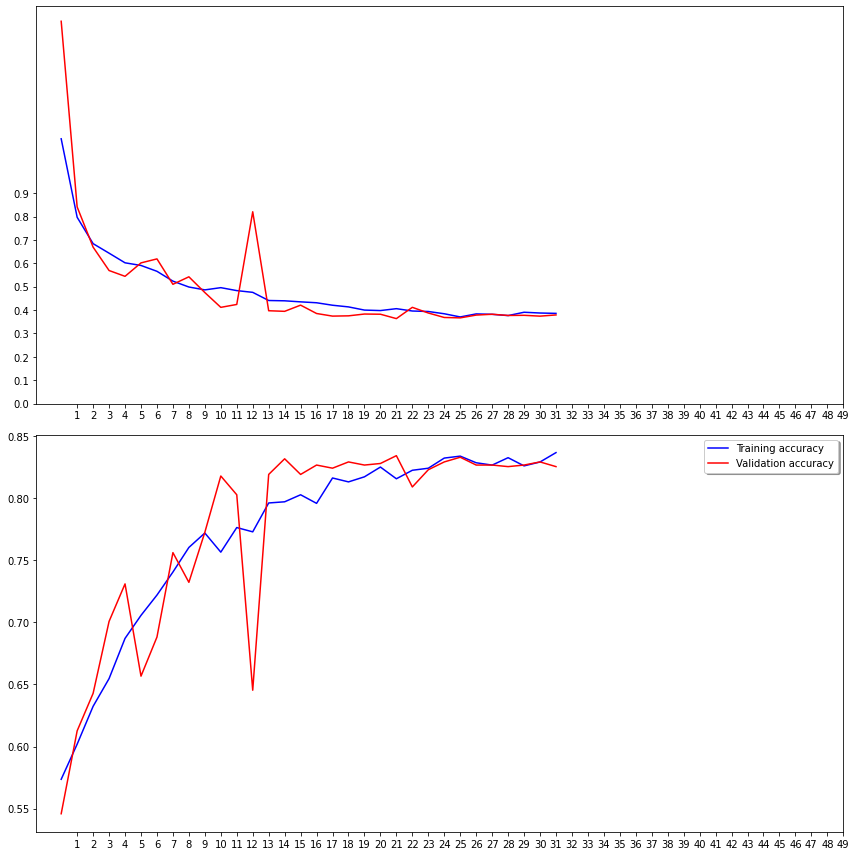

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Kuliah/dicoding/imageclassification/model_dogvscat.h5")

In [ ]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/Kuliah/dicoding/imageclassification/model_dogvscat.h5")

In [ ]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tflite_converter.convert()
open("/content/drive/MyDrive/Kuliah/dicoding/imageclassification/tf_lite_model_dogvscat.tflite", "wb").write(tflite_model)

51767156